## Sentiment Analysis of Amazon Review Data

Dieses Notebook beinhaltet die komplette Sentiment Analyse auf Basis der bereinigeten Amazon Review Daten

In [1]:
#Import aller benötigten Module
import json
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile, f_classif
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix


#Unterdrückung von Update Hinweisen
import warnings
warnings.filterwarnings('ignore')

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Einlesen der Reviewdaten und Hinzufügen eines Labels

In [2]:
#Import der Config Datei - genutzt um das Sentiment auf die Sternebewertung zu übertragen
with open('config.json') as json_data_file:
    config = json.load(json_data_file)

In [3]:
#Einlesen der Datensätze, die die Preprocessing Schritte durchlaufen sind
data = pd.read_csv("./Data_filtered/reviews_Beauty.csv", sep=";")
data.head(5)

,review,rating,product
0,"['oily', 'creamy', 'expected', 'ordered', 'try...",1.0,7806397051
1,"['palette', 'decent', 'price', 'looking', 'dif...",3.0,7806397051
2,"['texture', 'concealer', 'pallet', 'fantastic'...",4.0,7806397051
3,"['really', 'tell', 'exactly', 'thing', 'powder...",2.0,7806397051
4,"['little', 'smaller', 'expected', 'okay', 'las...",3.0,7806397051


In [4]:
#Hinzufügen eines Sentiment labels, auf Basis der Config Datei
#Aktuell 1, 2, 3 = negativ 4, 5 = positiv
data["label"] = pd.cut(data["rating"], bins = config["label_two"]["bins"], labels = config["label_two"]["labels"])
data["label"] = data["label"].astype(str)
data.head(5)

,review,rating,product,label
0,"['oily', 'creamy', 'expected', 'ordered', 'try...",1.0,7806397051,negativ
1,"['palette', 'decent', 'price', 'looking', 'dif...",3.0,7806397051,negativ
2,"['texture', 'concealer', 'pallet', 'fantastic'...",4.0,7806397051,positiv
3,"['really', 'tell', 'exactly', 'thing', 'powder...",2.0,7806397051,negativ
4,"['little', 'smaller', 'expected', 'okay', 'las...",3.0,7806397051,negativ


### Möglichkeit den Datensatz gleichverteilt aufzubauen 

In [5]:
#Build an evenly distributed dataframe
positiv = data[data['label'] =='positiv']
negativ = data[data['label'] =='negativ']

positiv_sample = positiv.sample(n=negativ.label.count(), replace=False, random_state=42)

#Merge postiv und negativ dataframe
balanced_dataset = pd.concat([negativ, positiv_sample])
#Anzahl an Reviews im gleichverteilten Datensatz
balanced_dataset.label.count()

88460

#### Splitten der gleichverteilten Daten in Test und Trainingsdaten

In [6]:
#Gleichverteilte Daten
X_train, X_test, y_train, y_test = train_test_split(balanced_dataset['review'], balanced_dataset['label'], test_size=0.2, random_state=42, stratify=balanced_dataset['label'])

#### Splitten der unveränderten Reviewdaten in Test und Trainingsdaten

In [7]:
#Verteilung der Sentimente wie in den Review
X_train, X_test, y_train, y_test = train_test_split(data['review'], data['label'], test_size=0.2, random_state=42, stratify=data['label'])

### Definition der Vectorizer, Begrenzung der Features und Auswahl der Classifiers

In [8]:
#Vectorizer
vect = CountVectorizer(stop_words="english")
#vect = TfidfVectorizer()

#feature selection
#f_select = SelectKBest(f_classif, k=10000)
f_select = SelectPercentile(f_classif, percentile=20)

#Classifier
#clf = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)
#clf = LinearSVC(C=1.0, penalty= "l1", max_iter=3000, dual=False)
#clf = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=42)
clf = LogisticRegression(random_state=42, class_weight=None, max_iter=3000)


#Building the Pipeline
pipeline = Pipeline([('vect', vect),
                     ('f_select', f_select), 
                     ('clf', clf)])

### Trainieren des Models

In [9]:
#Trainieren des Models
model = pipeline.fit(X_train, y_train)

#Results step of Pipeline
vectorizer = model.named_steps['vect']
feature_selection = model.named_steps['f_select']
classifier = model.named_steps['clf']

#Accuracy score of Train Data
print("accuracy score: " + str(model.score(X_train, y_train)))

accuracy score: 0.8832878886153109


### Testen des Models

In [10]:
#Falls gleichverteilte Daten zum Trainieren benutzt wurden, können hier wieder die unveränderten Daten zum Testen definiert werden
X_train, X_test, y_train, y_test = train_test_split(data['review'], data['label'], test_size=0.2, random_state=42, stratify=data['label'])

In [11]:
#Accuracy Score of Model prediction 
print("accuracy score: " + str(model.score(X_test, y_test)))

#Report on prediction of model
predictions = model.predict(X_test)
print("Classificaton Report:")
print(metrics.classification_report(y_true=y_test, y_pred=predictions))

accuracy score: 0.8543613510994685
Classificaton Report:
             precision    recall  f1-score   support

    negativ       0.75      0.52      0.62      8846
    positiv       0.87      0.95      0.91     30855

avg / total       0.85      0.85      0.84     39701



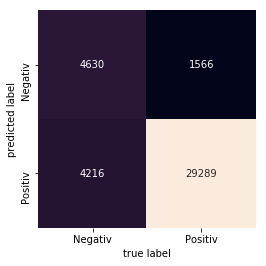

In [12]:
#Confusion matrix of model
labels = model.predict(X_test)
target_names = ['Negativ', 'Positiv']
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

### Einsatz der Kreuzvalidierung

In [13]:
from sklearn.model_selection import cross_val_score,  KFold

#kfold
kfold = KFold(n_splits=5)

#StratifiedKFold
#standard for cv=INT is stratified k-fold

scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print("Cross-validation scores: {}".format(scores))
print("Mean accuracy: {}".format(scores.mean()))

Cross-validation scores: [0.85334215 0.85526274 0.85277078 0.85352645 0.85301804]
Mean accuracy: 0.8535840328283963


In [14]:
from sklearn.model_selection import cross_validate
res = cross_validate(pipeline, X_train, y_train, cv=5, return_train_score=True)

#make DataFrame of result for better Visualisation
res_df = pd.DataFrame(res)
display(res_df)

#Print Mean of all Scores
print("Mean times and scores:\n", res_df.mean())

,fit_time,score_time,test_score,train_score
0,35.855841,1.733206,0.853342,0.884430
1,58.155965,1.785182,0.855263,0.883911
2,35.080647,1.759177,0.852771,0.884108
3,37.218426,1.809130,0.853526,0.884738
4,32.996804,1.792144,0.853018,0.885479


Mean times and scores:
 fit_time       39.861537
score_time      1.775768
test_score      0.853584
train_score     0.884533
dtype: float64


### Manuelles Testen mit Reviews

In [15]:
#Test with Manual review Text
print(model.predict(["The product is very bad"]))
print(model.predict(['My order broke and I am very disappointed']))
print(model.predict(['My order works perfect and and I am very glad I bought it']))

['positiv']
['negativ']
['positiv']


In [16]:
#Test mit LIDL Reviews
print(model.predict(['I found it a bit too rich. But heated up with some cream it is the most amazing taste']))
print(model.predict(['Nice, but too sweet for me. Would prefer the icing to be more bitter. It would then complement the rich cake']))
print(model.predict(['Very rich but moreish. The chocolate is creamy but the sponge is just ideal. It crumbles where it is so fresh. I find this cake tastes best served with cream or even a good vanilla ice-cream. The cake may not seem large enough, but it is a luxury cake so you would only need a sensible sized portion to enjoy it at its best.']))
print(model.predict(["I haven't seen this in my shop recently."]))

['positiv']
['positiv']
['positiv']
['positiv']


### Untersuchung der Predictions

In [17]:
# Erstellung eines DataFrames mit den Spalten: X_test, y_test, prediction
predictions = model.predict(X_test)
df_prediction = pd.DataFrame({
    'X_test': X_test,
    'y_test': y_test,
    'prediction': predictions
})

# neue Spalte, die Values von Spalten y_test und prediction vergleicht
df_prediction['vergleich'] = df_prediction['y_test'] == df_prediction['prediction']

df_prediction.head()

,X_test,y_test,prediction,vergleich
182751,"['glides', 'smooth', 'skin', 'seems', 'bright'...",positiv,positiv,True
97055,"['warm', 'red', 'orange', 'great', 'color', 'p...",positiv,positiv,True
113998,"['shade', 'pretty', 'call', 'thirty-four', 'ba...",positiv,positiv,True
70398,"['bigger', 'hair', 'always', 'little', 'fun', ...",positiv,positiv,True
138697,"['never', 'used', 'hairspray', 'recently', 'de...",negativ,positiv,False


In [18]:
# Speichern der Zeilen mit unterschiedlichen Werten in den Spalten "y_test" und "prediction" in einem neuen DF 
# und setzt Index zurück 
df_false_predictions = df_prediction[df_prediction.vergleich == False].reset_index(drop = True)
df_false_predictions.head()

,X_test,y_test,prediction,vergleich
0,"['never', 'used', 'hairspray', 'recently', 'de...",negativ,positiv,False
1,"['ordered', 'wig', 'wear', 'american', 'dream'...",negativ,positiv,False
2,"['highlighted', 'hair', 'stylist', 'recommende...",negativ,positiv,False
3,"['bought', 'based', 'glorious', 'reviews', 'pe...",positiv,negativ,False
4,"['expected', 'small', 'samples', 'full', 'bott...",negativ,positiv,False


In [19]:
# Erstellung einer CSV Datei mit den falsch predicteden Zeilen
df_false_predictions.to_csv("false_predictions.csv", sep=';',index=False)

In [20]:
# Ausgabe eines Reviews, das negativ ist aber positiv predicted wurde
predict_false_positiv = df_false_predictions[df_false_predictions['prediction'] == 'positiv']
predict_false_positiv['X_test'].iloc[0]

"['never', 'used', 'hairspray', 'recently', 'decide', 'try', 'see', 'would', 'help', 'hold', 'curls', 'naturally', 'straightish', 'hair', 'little', 'bit', 'wave', 'never', 'able', 'keep', 'curls', 'hours', 'bought', 'small', 'travel', 'size', 'frizz', 'ease', 'walmart', 'gave', 'side', 'bangs', 'bit', 'curl', 'sprayed', 'curl', 'froze', 'move', 'next', 'twelve', 'hoursbut', 'seriously', 'sisters', 'hate', 'hair', 'spray', 'say', 'makes', 'hair', 'crispy', 'agree', 'smell', 'gives', 'headaches', 'keep', 'spraying', 'eye', 'mist', 'like', 'people', 'say', 'hairspray', 'ought', 'either', 'holds', 'well', 'well', 'ask', 'lookout', 'pliable', 'hairspray', 'make', 'feel', 'like', 'slathered', 'glue', 'head', 'ever', 'need', 'super', 'duper', 'strong', 'hair', 'glue', 'sure', 'top', 'list']"

In [21]:
# Ausgabe eines Reviews, das positiv ist aber negativ predicted wurde
predict_false_negativ = df_false_predictions[df_false_predictions['prediction'] == 'negativ']
predict_false_negativ['X_test'].iloc[0]

"['bought', 'based', 'glorious', 'reviews', 'personally', 'never', 'used', 'vit', 'e', 'oil', 'sure', 'expect', 'thick', 'much', 'thicker', 'castor', 'oil', 'easy', 'spread', 'around', 'greasy', 'put', 'face', 'realized', 'going', 'spoil', 'pillow', 'covers', 'also', 'spreads', 'hair', 'makes', 'hair', 'greasy', 'yet', 'see', 'works', 'coz', 'soon', 'comment', 'results', 'coz', 'used', 'times', 'would', 'like', 'prospective', 'buyers', 'know', 'wear', 'makeup', 'fact', 'bed', 'sure', 'would', 'good', 'time', 'put']"